# <center>제 1차 해커톤 (대전) : 캐글 축제</center>
---------
## <center>주제 : Predict Future Sales</center>
<center>1조 : 박은지, 이준택, 임선옥</center>

**`평가기준`**
- 제출 파일은 jupyter notebook이고, 형식은 Exploration 노드 과제 제출 형식과 동일합니다. (결과 출력, 로그 및 주요사항 reporting)
- 캐글 Public Score 기준 순위 확인
> - My Submission Page를 캡쳐하여 제출
>- Public Score Leaderboard 캡쳐하여 제출
>- 단, 해당 점수 획득과정이 기술된 jupyter notebook 미제출시 불인정

- 분석 과정 및 시각화등 우수 조 추가 시상 (특별상)
> - **EDA 및 Visualization이 독특하고 우수한 조**
> - **전체 프로젝트의 과정(History)이 창의적으로 정리된 조**
> - `jupyter notebook`에 팀원간의 협력이 효과적으로 드러난 조

**`순서`**
>1. **개요**
>2. **설명**
>3. **데이터 이해하기**
>4. **모델설계 및 튜닝**
>5. **결과**

## 1. 개요
---
이 과제는 "How to win a data science competition(데이터 과학 경쟁에서 이기는 방법)" 과정의 최종 프로젝트입니다.

이 대회에서는 러시아 최대 소프트웨어 회사인 1C Company에서 제공하는 일일 판매 데이터로 구성된 까다로운 시계열 데이터 세트로 작업합니다.

**<span style = color:red>다음 달의 모든 제품 및 상점에 대한 총 매출액을 예측</span>**하도록 요청하고 있습니다.<br>이 경쟁을 해결함으로써 여러분은 데이터 과학 기술을 적용하고 향상시킬 수 있을 것입니다.

## 2. 설명

#### Data Description
> You are provided with daily historical sales data.<br>The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month.<br>Creating a robust model that can handle such situations is part of the challenge.

#### `File descriptions`
- **<span style = color:blue>sales_train.csv</span>** : the training set. Daily historical data from January 2013 to October 2015.
- **<span style = color:blue>test.csv</span>** : the test set. You need to forecast the sales for these shops and products for November 2015.
- **<span style = color:blue>sample_submission.csv</span>** : a sample submission file in the correct format.
- **<span style = color:blue>items.csv</span>** : supplemental information about the items/products.
- **<span style = color:blue>item_categories.csv</span>**  : supplemental information about the items categories.
- **<span style = color:blue>shops.csv</span>** : supplemental information about the shops.

#### `Data fields`
- **<span style = color:green>ID</span>** : an Id that represents a (Shop, Item) tuple within the test set
- **<span style = color:green>shop_id</span>** : unique identifier of a shop
- **<span style = color:green>item_id</span>** : unique identifier of a product
- **<span style = color:green>item_category_id</span>** : unique identifier of item category
- **<span style = color:green>item_cnt_day</span>** : number of products sold. You are predicting a monthly amount of this measure
- **<span style = color:green>item_price</span>** : current price of an item
- **<span style = color:green>date</span>** : date in format dd/mm/yyyy
- **<span style = color:green>date_block_num</span>** : a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **<span style = color:green>item_name</span>** : name of item
- **<span style = color:green>shop_name</span>** : name of shop
- **<span style = color:green>item_category_name</span>** : name of item category

**This dataset is permitted to be used for any purpose, including commercial use.**

**✓ 필요한 라이브러리 import 하기**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

print('얍💢')

얍💢


**`✓ 데이터 경로 지정하기(우리가 로컬에서 사용할 때 알맞은 파일 경로)`**

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_festival/data'

train_data_path = join(data_dir, 'sales_train.csv')
sub_data_path = join(data_dir, 'test.csv') 

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj49/aiffel/kaggle_festival/data/sales_train.csv
/home/aiffel-dj49/aiffel/kaggle_festival/data/test.csv


**✓ 데이터 불러오기**

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

# 데이터수와 컬럼수 출력
print('train_data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train_data dim : (2935849, 6)
sub data dim : (214200, 3)


학습 데이터는 약 2만 9천 개, 테스트 데이터는 약 2만 개로 이루어져 있군요.<br>
어떤 컬럼들로 이뤄져 있는지 봅시다.

In [4]:
print("train keys :", data.keys())
print("sub keys :", sub.keys())

train keys : Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
sub keys : Index(['ID', 'shop_id', 'item_id'], dtype='object')


In [5]:
s = pd.DataFrame(data)
s

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [6]:
a = pd.DataFrame(sub)
a

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


**✓ 간단한 전처리 : 결측치 확인**

아래에 출력된 것은 **data**라는 **DataFrame**을 매트릭스 모양 그대로 시각화한 것입니다.<br>만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 `하얗게` 나옵니다.<br>결측치가 없다면 매트릭스 전체가 까맣게 나올 겁니다. 

<AxesSubplot:>

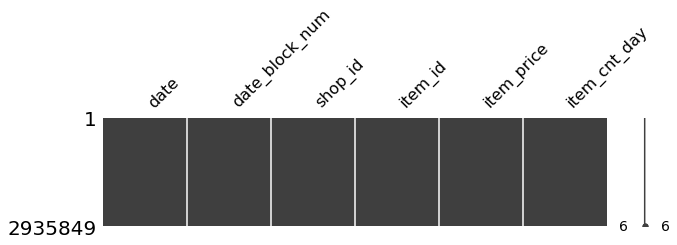

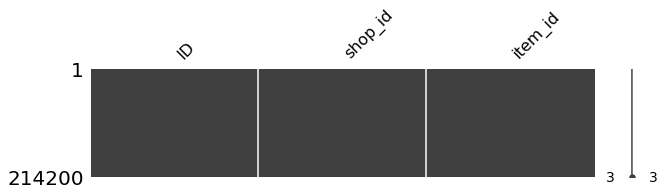

In [7]:
# missingno 라이브러리의 matrix 함수를 사용하여 데이터의 결측 상태 시각화
msno.matrix(data, figsize=(10, 2))
msno.matrix(sub, figsize=(10,2))

아래와 같이 직접 결측치의 개수를 출력해서 확인할 수도 있습니다.

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [9]:
for c in sub.columns:
    print('{} : {}'.format(c, len(sub.loc[pd.isnull(sub[c]), c].values)))

ID : 0
shop_id : 0
item_id : 0


**✓ outlier 제거 : 이상치 데이터를 제거** 

In [12]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train)

NameError: name 'train' is not defined

<Figure size 720x216 with 0 Axes>

In [13]:
train = train[train.item_cnt_day < 500]
train = train[train.item_price < 50000]

NameError: name 'train' is not defined

In [14]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=train)

NameError: name 'train' is not defined

<Figure size 720x216 with 0 Axes>

In [ ]:
train.describe()

In [ ]:
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

**✓ 학습 데이터에서 라벨 제거하기**

In [ ]:
print(data.columns)

In [ ]:
# 학습 데이터에서 date, item_price제거
del train['date']
del train['item_price']

# 정답 데이터 저장 후, 삭제
y = train['item_cnt_day']
del train['item_cnt_day']

print(data.columns)
print(sub.columns)

**✓ 학습 데이터와 테스트 데이터 합치기**

모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 **`pd.concat`**으로 합쳐봅니다.

물론, 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 **`train_len`**에 **`training data`**의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.



In [ ]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

In [ ]:
data.head()

**✓ <span style = color:green>id, date</span> 변수 정리**

In [ ]:
sub_id = data['ID'][train_len:]
del data['ID']

print(data.columns)

In [ ]:
# data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

**✓ 각 변수들의 분포 확인**

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(5):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 4 :
            break

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [ ]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.<br>

위에서 저장해두었던 **train_len**을 인덱스로 활용해서 **:train_len**까지는 학습 데이터, 즉 **x**에 저장하고, **train_len:** 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 **sub** 변수에 저장합니다.

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

**✓ 모델링**

이제 본격적으로 학습시킬 모델을 준비합니다.<br>Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, **`블렌딩(blending)`** 이라는 기법을 활용합니다.<br>블렌딩은 **`앙상블 기법`**이라고 하기도 하는데요.<br>하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다.

**✓ Average Blending**

여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들겠습니다.

모델은 부스팅 계열인 **`gboost`, `xgboost`, `lightgbm`** 세 가지를 사용합니다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

**✓ Cross Validation**

교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))
print('얍💢')

In [ ]:
get_cv_score(models)

**✓ Make Submission File**

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

좋습니다! 함수를 활용해서 예측값을 생성해 볼까요?

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

우리는 이 결과를 캐글에 제출하기 위해 어떻게 해야 할까요?

제출해야 하는 csv 파일의 샘플이 바로 **`data`** 폴더에 있는 **`sample_submission.csv`** 입니다.<br>
다음 코드로 **`sample_submission.csv`** 파일을 확인해보겠습니다.

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_festival/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

좋습니다! 이제 제출할 일만 남았습니다.<br>다음 코드로 **`submission.csv`** 파일을 저장해 주세요!

In [ ]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)